# Brain Tumor Classification
In this notebook, I will be using PyTorch to classify Brain Tumor.

In [68]:
import os

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

os.listdir(train_dir), os.listdir(test_dir)

(['pituitary', 'notumor', 'meningioma', 'glioma'],
 ['pituitary', 'notumor', 'meningioma', 'glioma'])

# Import Dependencies

In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt
import torchvision

print(torchvision.__version__)

0.20.1+cu121


# Setup Device Agnostic code

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load and Transform Data Function
Turn data into dataset then turn dataset into data loader

In [116]:
def get_data(train_dir, test_dir, batch_size):
    # define transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # convert grayscale to RGB
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # define dataset
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # define data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_dataset, test_dataset, train_dataloader, test_dataloader

# Get Model Function

In [72]:
def get_model():
    # Use the default pretrained weights
    model = efficientnet_b0(weights='DEFAULT')

    # modify final layer to 4 classes -> glioma, meningioma, notumor, pituitary
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 4)

    # move model to device
    model = model.to(device)

    return model

# Training and Test Loop Function

In [73]:
def training_and_test_loop(train_dataloader, test_dataloader, model, n_epochs):
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # track history
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    best_test_acc = 0

    # epoch loop
    for epoch in range(n_epochs):
        # initialize epoch_train_loss and epoch_train_acc
        epoch_train_loss = 0
        epoch_train_acc = 0

        # batch loop for train mode
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            model.train()
            # zero grad
            optimizer.zero_grad()
    
            # forward pass
            preds = model(X)

            # calculate loss and accuracy
            loss = criterion(preds, y)
            accuracy = torch.sum(preds.argmax(dim=1) == y) / len(preds)

            # backward propagation and optimizer step
            loss.backward()
            optimizer.step()
            
            # accumulate epoch_train_loss and epoch_train_acc
            epoch_train_loss += loss.item()
            epoch_train_acc += accuracy.item()

        # epoch level averages and append to history for train mode
        epoch_train_loss /= len(train_dataloader)
        epoch_train_acc /= len(train_dataloader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # initialize epoch_test_loss and epoch_test_acc
        epoch_test_loss = 0
        epoch_test_acc = 0
        
        # batch loop for test mode
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            with torch.inference_mode():
                # forward pass
                preds = model(X)

                # calculate loss and accuracy
                loss = criterion(preds, y)
                accuracy = torch.sum(preds.argmax(dim=1) == y) / len(preds)

                # accumulate epoch_test_loss and epoch_test_acc
                epoch_test_loss += loss.item()
                epoch_test_acc += accuracy.item()

        # epoch level averages and append to history for test mode
        epoch_test_loss /= len(test_dataloader)
        epoch_test_acc /= len(test_dataloader)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        # log epoch result
        print(f"Epoch: {epoch+1} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc*100:.2f}%")

        # track best model
        if epoch_test_acc > best_test_acc:
            best_test_acc = epoch_test_acc
            torch.save(model.state_dict(), "brain_tumor_classifier.pth")
            print(f"Best Model at Epoch: {epoch+1} with Accuracy: {epoch_test_acc*100:.2f}% | Saving Model's state_dict....")

    return train_loss, train_acc, test_loss, test_acc

# Run EVERYTHING

In [74]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_data(train_dir, test_dir, 32)
model = get_model()
train_loss, train_acc, test_loss, test_acc = training_and_test_loop(train_dataloader, test_dataloader, model, 20)

Epoch: 1 | Train Accuracy: 0.9071 | Test Accuracy: 96.49%
Best Model at Epoch: 1 with Accuracy: 96.49% | Saving Model's state_dict....
Epoch: 2 | Train Accuracy: 0.9555 | Test Accuracy: 92.07%
Epoch: 3 | Train Accuracy: 0.9693 | Test Accuracy: 98.55%
Best Model at Epoch: 3 with Accuracy: 98.55% | Saving Model's state_dict....
Epoch: 4 | Train Accuracy: 0.9787 | Test Accuracy: 97.48%
Epoch: 5 | Train Accuracy: 0.9817 | Test Accuracy: 96.41%
Epoch: 6 | Train Accuracy: 0.9789 | Test Accuracy: 98.93%
Best Model at Epoch: 6 with Accuracy: 98.93% | Saving Model's state_dict....
Epoch: 7 | Train Accuracy: 0.9810 | Test Accuracy: 97.79%
Epoch: 8 | Train Accuracy: 0.9880 | Test Accuracy: 97.94%
Epoch: 9 | Train Accuracy: 0.9883 | Test Accuracy: 98.24%
Epoch: 10 | Train Accuracy: 0.9890 | Test Accuracy: 99.00%
Best Model at Epoch: 10 with Accuracy: 99.00% | Saving Model's state_dict....
Epoch: 11 | Train Accuracy: 0.9934 | Test Accuracy: 99.16%
Best Model at Epoch: 11 with Accuracy: 99.16% | Sav

# Plot History

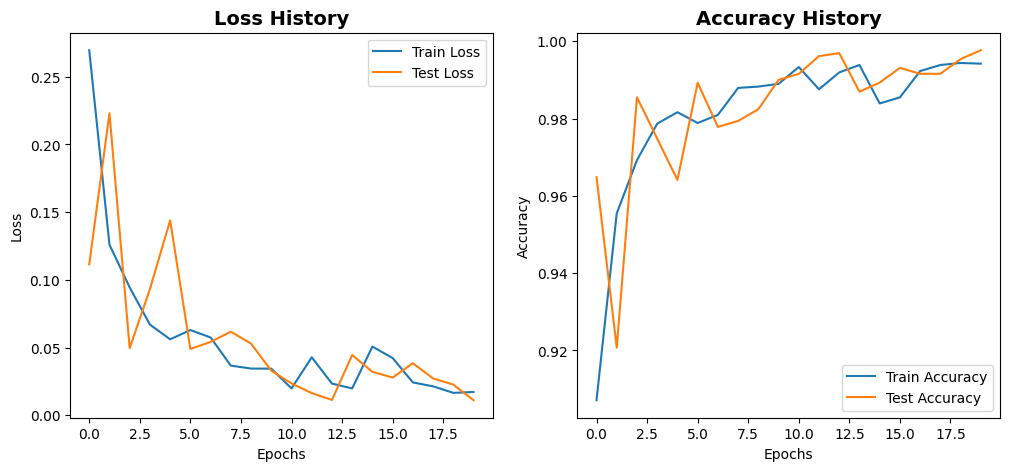

In [167]:
def plot_history(train_loss, train_acc, test_loss, test_acc):
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History', fontsize=14, fontweight='bold')

    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History', fontsize=14, fontweight='bold')
    
    plt.tight_layout;

plot_history(train_loss, train_acc, test_loss, test_acc)

# Show 12 Sample Images from test_dataset

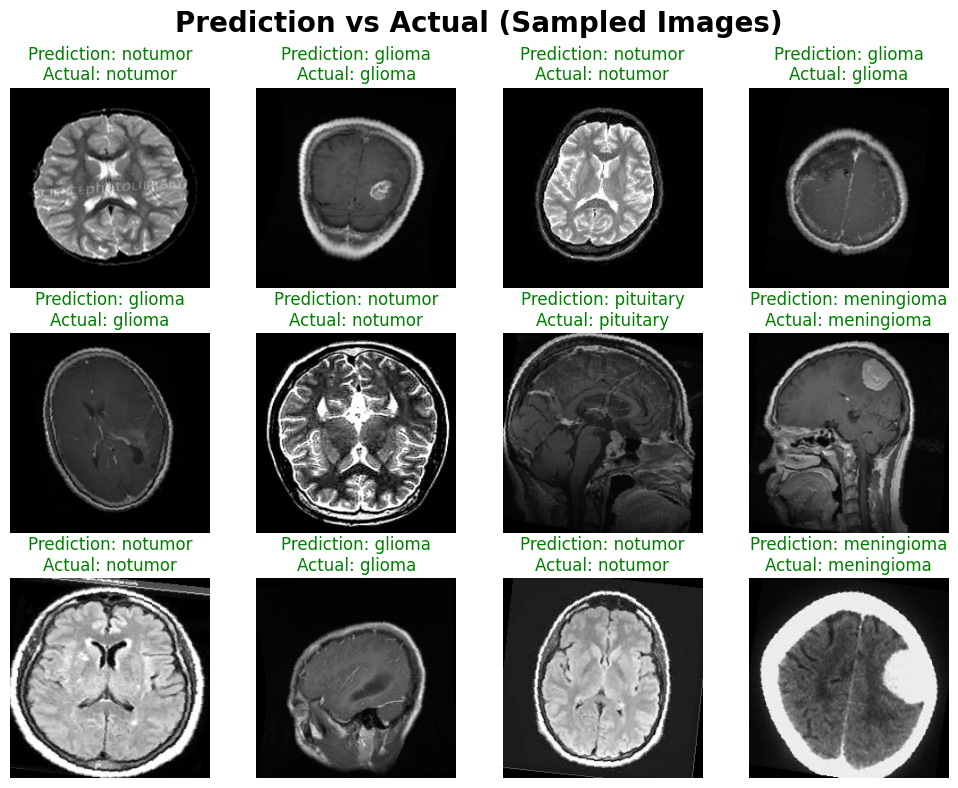

In [157]:
def plot_12_images(test_dataset):
    # generate random indices in range batch_size
    random_indices = torch.randint(0, len(test_dataset), (12,))

    # index random images and labels
    random_samples = [test_dataset[i] for i in random_indices]
    random_images, random_labels = zip(*random_samples)

    # get predictions for random_images
    model = get_model()
    model.load_state_dict(torch.load("brain_tumor_classifier.pth", weights_only=True))
    model.eval()
    with torch.inference_mode():
        preds = model(torch.stack(random_images).to(device)).argmax(dim=1).cpu()

    # class names
    class_names = test_dataset.classes

    # plotting
    plt.figure(figsize=(10,8))
    for i, (image, label, pred) in enumerate(zip(random_images, random_labels, preds)):
        plt.subplot(3, 4, i+1)
        plt.imshow(image.permute(1,2,0).mean(dim=-1), cmap='gray')
        if label == pred:
            plt.title(f"Prediction: {class_names[pred]}\nActual: {class_names[label]}", c='g')
        else:
            plt.title(f"Prediction: {class_names[pred]}\nActual: {class_names[label]}", c='r')
        plt.axis("off")
    plt.suptitle("Prediction vs Actual (Sampled Images)", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_12_images(test_dataset)